In [11]:
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.dirname('../.'))
from ml.get_model import get_model
from ml.SampleClass import Sample
from ml.ControllerClass import Controller
from scripts.utils import get_path
from scripts.load_and_save import save_vol_as_nii

/tmp/ipykernel_3277/2931518097.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  if (img[i, j, 0] > 1.2*(img[i, j, 1]+img[i, j, 2]))*(img[i, j, 0]<100)*(img[i, j, 0]>40):


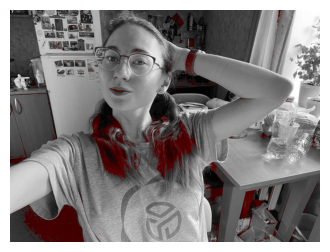

In [54]:
import numpy as np
from PIL import Image

img_ = np.asarray(Image.open('/home/msst/Nast2.jpg'))
img = img_*1

#img[:, :, 1] = np.zeros_like(1*img[:, :, 0])
#img[:, :, 2] = np.zeros_like(1*img[:, :, 0])

#img[:, :, 0] = np.where((img[:, :, 0]>img[:, :, 1]*img[:, :, 2])*(img[:, :, 0]>127),
#                        img[:, :, 0], img[:, :, 0])

for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (img[i, j, 0] > 1.2*(img[i, j, 1]+img[i, j, 2]))*(img[i, j, 0]<100)*(img[i, j, 0]>40):
            img[i, j, 1] = 0
            img[i, j, 2] = 0
        else:
            img[i, j, :] = np.array(3*(img[i, j, :].mean(),))
        
        
# fig, ax = plt.subplots(2, 2, figsize = (8,8), gridspec_kw = {'wspace':0.01, 'hspace':0.2})
        
# ax[0][0].set_axis_off()
# ax[0][1].set_axis_off()
# ax[1][0].set_axis_off()
# ax[1][1].set_axis_off()

# ax[0][0].imshow(img)
# ax[0][1].imshow(img[:, :, 0])
# ax[1][0].imshow(img[:, :, 1])
# ax[1][1].imshow(img[:, :, 2])

fig, ax = plt.subplots(1, 1, figsize = (4,4), gridspec_kw = {'wspace':0.01, 'hspace':0.2})
     
#ax[0].set_axis_off()
#ax[0].imshow(img_)
    
ax.set_axis_off()
ax.imshow(img)

fig.savefig(f'/home/msst/Nast_results.jpg', dpi=250)

**<h1>MIP**

In [2]:
CROP_COEF = 0.08
def transform_to_show(img):
    crop = (np.array(img.shape)*CROP_COEF).astype(int)
    img_out = img[crop[0]:-crop[0], crop[1]:-crop[1]]*1 
    return np.flip(img_out.T, axis=0)

def get_errors_image(MIP_GT, MIP_SEG):
    SIZE = MIP_GT.shape
    Errors = np.zeros((SIZE[0], SIZE[1], 3))
    Errors[:, :, 1][(MIP_GT>0)*(MIP_GT==MIP_SEG)] = 1
    Errors[:, :, 2][MIP_GT>MIP_SEG] = 1
    Errors[:, :, 0][MIP_GT<MIP_SEG] = 1
    return(Errors)

In [3]:
#model_name = 'Unet2d_16ch'
#model_name = 'Unet3d_16ch'
#model_name = 'HessNet'
model_name = 'HessUNet_depth3'

sample_name = 'IXI111'

In [4]:
path_to_GT = f'/home/msst/Documents/medtech/data/Inference_IXI/{sample_name}'
path_to_SEG = get_path(f'/home/msst/IXI_MRA_work/{sample_name}', model_name)
#GT
sample = Sample(path_to_GT)
subject = sample.get_subject()
vessels_GT = subject.vessels.data[0].numpy()
brain = subject.brain.data[0].numpy()
vessels_GT_masked = vessels_GT*brain

#SEG
img = tio.LabelMap(path_to_SEG)
vessels_SEG = img.data[0].numpy()
vessels_SEG_masked = vessels_SEG*brain



#MIP
MIP_GT = transform_to_show(np.max(vessels_GT, axis=2))
MIP_GT_masked = transform_to_show(np.max(vessels_GT_masked, axis=2))

MIP_SEG = transform_to_show(np.max(vessels_SEG, axis=2))
MIP_SEG_masked = transform_to_show(np.max(vessels_SEG_masked, axis=2))

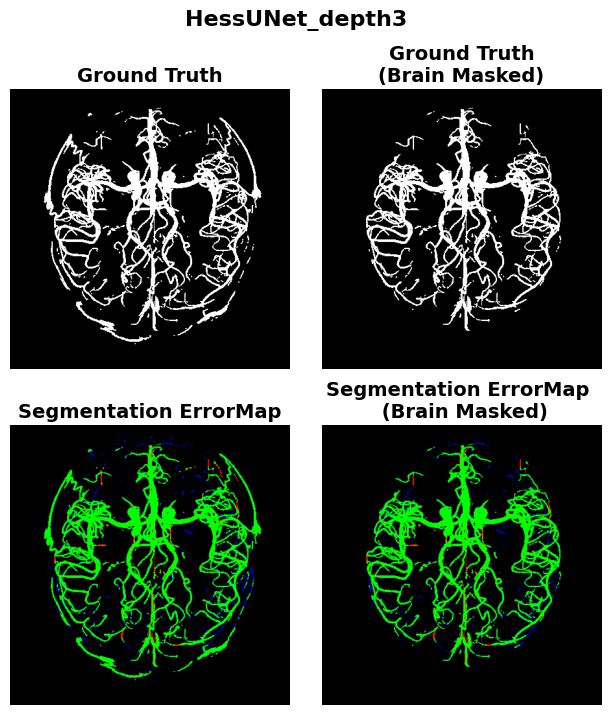

In [5]:
fig, ax = plt.subplots(2, 2, figsize = (8,8), gridspec_kw = {'wspace':0.01, 'hspace':0.2})

ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()

ax[0][0].imshow(MIP_GT, cmap='gray')
ax[0][0].set_title("Ground Truth", fontsize = 14, fontweight ='bold') 
ax[0][1].imshow(MIP_GT_masked, cmap='gray')
ax[0][1].set_title("Ground Truth\n(Brain Masked)", fontsize = 14, fontweight ='bold') 

ax[1][0].imshow(get_errors_image(MIP_SEG, MIP_GT))
ax[1][0].set_title("Segmentation ErrorMap", fontsize = 14, fontweight ='bold') 
ax[1][1].imshow(get_errors_image(MIP_SEG_masked, MIP_GT_masked))
ax[1][1].set_title("Segmentation ErrorMap \n (Brain Masked)", fontsize = 14, fontweight ='bold') 

fig.suptitle(f'{model_name}', fontsize=16, fontweight ='bold')

fig.savefig(f'/home/msst/ArticleImages/{model_name}_results.jpg', dpi=250)

In [6]:
def get_error_vol(vol_GT, vol_SEG):
    assert vol_GT.shape == vol_SEG.shape
    error_vol = np.zeros_like(vol_GT, dtype=np.uint8)
    error_vol[(vol_GT>0)*(vol_GT==vol_SEG)] =1
    error_vol[(vol_GT>vol_SEG)]=2
    error_vol[(vol_GT<vol_SEG)]=3
    return(error_vol)

In [7]:
error_vol = get_error_vol(vessels_GT_masked, vessels_SEG_masked)

In [8]:
path_to_save_sample = f'/home/msst/IXI_MRA_work/{sample_name}/{model_name}_ErrorMap.nii.gz'
save_vol_as_nii(error_vol, subject.head.affine, path_to_save_sample)

**<h1>Learning History**

In [9]:
DEVICE = 'cuda'
IS2D = False

#model_name = 'Unet2d_16ch'
#model_name = 'Unet3d_16ch'
#model_name = 'HessNet'
model_name = 'HessUNet'

controller_dict = {'device' : DEVICE,
                    'is2d' : IS2D,
                    'model': get_model(model_name)}

controller = Controller(controller_dict)

/home/msst/repo/MSRepo/VesselSegmentation/Notebooks/../ml/models/HessNet.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.HessBlocks.append(HessBlock(start_scale=(0.5+i/2)*torch.tensor(start_scale),


In [10]:
path_to_check = f"/home/msst/save_folder/models_for_tests/{model_name}_test1"
controller.load(path_to_checkpoint=path_to_check)

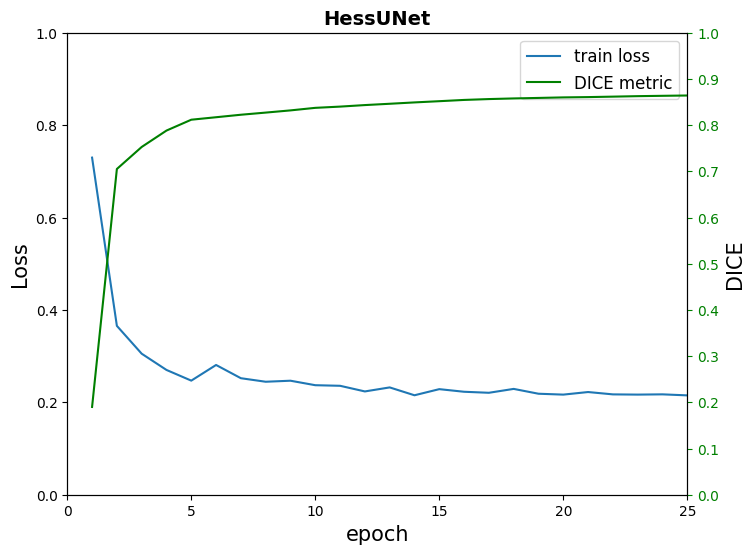

In [11]:
N_ep = len(controller.history['train_loss'])

epochs = np.linspace(1, N_ep, N_ep)
loss_train = controller.history['train_loss']
loss_val = controller.history['val_loss']
all_metrics = controller.history['test_quality']

avg_metrics = []
for epoch_metrics in all_metrics:
    metric = []
    for dict_ in epoch_metrics['metrics']:
        metric.append(dict_['metric1'].numpy())
    avg_metrics.append(sum(metric)/len(metric))


fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) 

ax.set_title(f"{model_name}", fontsize = 14, fontweight ='bold') 

twin1 = ax.twinx()
p1, = ax.plot(epochs, loss_train, label="train loss")
#p2, = ax.plot(epochs, loss_val, label="validation loss")
p3, = twin1.plot(epochs, avg_metrics, "g-", label="DICE metric")

ax.set_xlabel("epoch", fontsize=fontsize+3)
ax.set_ylabel("Loss", fontsize=fontsize+3)
twin1.set_ylabel("DICE", fontsize=fontsize+3)

twin1.tick_params(axis='y', colors=p3.get_color())


#ax.set_xticklabels(np.linspace(0, 50, 11).astype(int), fontsize=fontsize)
ax.set_xticks(np.linspace(0, N_ep, 6).astype(int))

#ax.set_yticklabels(np.linspace(0, 12, 7).astype(int), fontsize=fontsize)
#ax.set_yticks(np.linspace(0, 12, 7))

#twin1.set_yticklabels(np.round(np.linspace(0, 1, 6),1), fontsize=fontsize)
twin1.set_yticks(np.linspace(0, 1, 11))

ax.set_xlim(0, N_ep)
ax.set_ylim(0, 1)
twin1.set_ylim(0, 1)

ax.legend(handles=[p1, p3], fontsize=fontsize)

plt.savefig(f'/home/msst/ArticleImages/{model_name}_learning.jpg', dpi=100)